# Introduction
In this notebook, we'll take a look at Kanye West's song lyrics throughout the years, and try to find any patterns in them which might be a good proxy for how his personality has evolved over the years. Kanye has released music consistently since 2004, so hopefully this should provide a large enough sample for analysis.

# Data preparation

First I scraped all of his lyrics for songs where he is the main artist rather than a featured one (code can be found in https://github.com/meetco-a/The-Evolution-of-Kanye-West/blob/main/LyricsScrape.py) using the Genius API and stored them in a DataFrame, organized by year of release. I've then pickled the lyrics into a text file and load them when needed for analysis. This is so that I wouldn't need to scrape them every time I run this, as it takes a while to download all songs using the Genius API.

Next, I cleaned up the data:
* Remove missing lyrics and songs with missing dates
* Removing duplicate songs and multiple versions of the same song
* Removing all non-song entries
* Removing text within the lyrics which was not part of the lyrics, such as [Chorus], [Verse], etc.

# Analysis

Having scraped and cleaned the data, it's time for some analysis. For a start, I have chosen to look at a few measures and how they change over the years.
* **"I-words"** - I have defined a lexicon of words which refer to oneself, such as I, me, myself, as well as Kanye's own name and variations of it (Kanye, Ye, Yeezy). I then measure the occurrence of such words in each song.
* **"Greatness words"** - This measure is somewhat more subjective - I've defined a lexicon of words which I believe refer to what I call "greatness", such as best, top, perfect, champion, and all sorts of other words which someone may use to describe how great and amazing they are*.
* **Vocabulary size** - This is a simple measure of the number of unique words used in songs per year. Unique words are counted across the whole year to account for the same unique words being used across multiple songs. Stopwords are not counted.
* **Lexical density** - This is a simple measure of the ratio of non-stopwords to total words in a song.
* **Lexical diversity** - This is a measure of the ratio of unique words (non-stopwords) to total words in a song.
* **Lyrics sentiment (polarity)** - Using TextBlob, I measure the polarity of each song.

\*A limitation here is that this doesn't account for what those words are describing, i.e. Kanye may be using such words to describe other people or things and not himself.
***

### 1. Import necessary modules and clean data

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions import *
import pickle
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PIL import Image


###################################
# 1. DATA CLEANING #
###################################

# Load the scraped lyrics from the pickled file
infile = open("lyrics.txt", "rb")
dfLyrics = pickle.load(infile)
infile.close()

# Drop missing lyrics and missing years
dfLyrics = dfLyrics.dropna(subset=["Lyrics", "Date"])

# Drop duplicates and everything which is not a song (I've compiled this list after manual inspection)
searchFor = ["Freestyle", "Speech", "Reference", "Version", "Alternate", "Jools", "Sunday Service", "Demo", "Mix",
             "Sessions", "Mos Def", "Paparazzi", "monologue", "Taylor Swift", "Single Art", "^On ", "Lecture",
             "\[*\]", "Notepad", "Making of", "Still Standing", "OG", "Solo", "SNL", "2 Ryde"]
dfLyrics = dfLyrics[~dfLyrics["Song Title"].str.contains('|'.join(searchFor))]
dfLyrics.reset_index(inplace=True, drop=True)

# Add a new Year column and replace newlines with blank space in Lyrics; also drop tags, e.g. [Outro]
dfLyrics["Year"] = pd.DatetimeIndex(dfLyrics["Date"]).year
dfLyrics["Lyrics"] = dfLyrics["Lyrics"].str.replace("\n", " ")
dfLyrics["Lyrics"] = dfLyrics['Lyrics'].str.replace(r"\[[^\]]*\]", "")

# Drop songs where lyrics are not released or from leaked demo, as well as very short lyrics
dfLyrics = dfLyrics[~dfLyrics['Lyrics'].str.contains("Lyrics for this|Lyrics from")]
dfLyrics = dfLyrics[~dfLyrics['Lyrics'].apply(lambda x: len(x) < 10)]

### 2. Calculate features

In [2]:
###################################
# 2. CALCULATING FEATURES #
###################################

# I've defined two lexicons: I-words (words referring to oneself); and greatness words
# Here I load each lexicon and then count the occurrence of its words in each song
lexiconI = pd.read_table(os.path.join('Lexicons', 'i_words.txt'), index_col=0, sep='\t')
lexiconGreat = pd.read_table(os.path.join('Lexicons', 'greatness_words.txt'), index_col=0, sep='\t')

# Extract the list of regex patterns in each lexicon and compile them
patternListI = [re.compile(pattern, re.IGNORECASE) for pattern in lexiconI['Regex']]
patternListGreat = [re.compile(pattern, re.IGNORECASE) for pattern in lexiconGreat['Regex']]

# Count the number of pattern matches in each file for both lexicons and put them in a DataFrame
lyricsSeries = dfLyrics["Lyrics"]
matchCountI = count_patterns_series(patternListI, lyricsSeries)
matchCountGreat = count_patterns_series(patternListGreat, lyricsSeries)
countIDF = df_pattern_matches(dfLyrics, matchCountI, lexiconI)
countGreatDF = df_pattern_matches(dfLyrics, matchCountGreat, lexiconGreat)

# Finally, count total lexicon words per song and add new columns to the corpus
totalIWords = countIDF.sum(axis=1)
totalGreatWords = countGreatDF.sum(axis=1)
dfLyrics["I-words"] = totalIWords
dfLyrics["Greatness words"] = totalGreatWords

# The next measure we will use is the vocabulary size, i.e. number of unique words per song
# We'll count unique words per year to avoid duplicate counting of words
stops = stopwords.words('english')
totalWordsYear = pd.Series(np.zeros(len(dfLyrics["Year"].unique())))
uniqueWords = pd.Series(np.zeros(len(dfLyrics["Year"].unique())))
lexicalDiversity = pd.Series(np.zeros(len(dfLyrics["Year"].unique())))

for i, year in enumerate(dfLyrics["Year"].unique()):
    dfYear = dfLyrics[dfLyrics["Year"] == year]

    # Put all the lyrics for that year in one string, then use it to make a BoW
    lyricsYear = ''
    for lyrics in dfYear["Lyrics"]:
        lyricsYear += ' ' + lyrics

    # Make a bag of words from the lyrics and count number of unique words, removing stopwords
    aBOW = make_conventional_bow(lyricsYear)
    totalWordsYear[i] = sum(aBOW.values())
    for k, v in list(aBOW.items()):
        if k in stops or k == "":
            del aBOW[k]
    uniqueWords[i] = len(aBOW)
    lexicalDiversity[i] = uniqueWords[i]/totalWordsYear[i]
    # We'll attach this to the corpus later when we group by year


# Another measure we will use is lexical density, i.e. the ratio of non-stopwords to total words in a song
lexicalDensity = pd.Series(np.zeros(len(lyricsSeries)))
for i, lyrics in enumerate(lyricsSeries):
    aBOW = make_conventional_bow(lyrics)
    totalWords = sum(aBOW.values())
    nonStopWords = 0
    dictKeys = list(aBOW.keys())
    for entry in dictKeys:
        if entry not in stops:
            nonStopWords += aBOW[entry]

    if totalWords == 0:
        lexicalDensity[i] = 0
    else:
        lexicalDensity[i] = (nonStopWords/totalWords)*100

dfLyrics['Lexical density'] = lexicalDensity


# Using TextBlob, I measure each lyrics' sentiment
sentiment = dfLyrics.apply(lambda row: get_lyrics_sentiment(row["Lyrics"]), axis=1)
dfLyrics["Sentiment"] = sentiment

# Finally, we get average I-words/Greatness words/Vocabulary size per year
dfLyricsYear = dfLyrics[["Year", "I-words", "Greatness words", "Lexical density", "Sentiment"]]\
    .groupby(["Year"]).mean()
dfLyricsYear.reset_index(inplace=True)

# Since vocabulary size is grouped by year, we attach it to the DF here
dfLyricsYear["Vocabulary size"] = uniqueWords
dfLyricsYear["Lexical diversity"] = lexicalDiversity
dfLyricsYear["Total words"] = totalWordsYear

# Add number of songs per year as well and reset index
dfNoSongs = dfLyrics[["Year", "Date"]].groupby(["Year"]).count().reset_index()
dfLyricsYear["Number of Songs"] = dfNoSongs["Date"]

# Since there are a few years with no data (i.e. no songs released), we need to impute the missing data
# First I add each missing year to the DF with NaN values
for year in range(2003, 2021):
    if year not in dfLyricsYear['Year'].values:
        dfTemp = pd.DataFrame([[year, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 0]],
                              columns=list(dfLyricsYear.columns))
        dfLyricsYear = dfLyricsYear.append(dfTemp, ignore_index=True)

# Then we sort and re-index the data, and finally fill in the missing values using linear interpolation
dfLyricsYear.sort_values(by=['Year'], inplace=True)
dfLyricsYear.reset_index(drop=True, inplace=True)
dfLyricsYear.interpolate(method='linear', inplace=True)

In [16]:
dfLyricsYear.head(12)

,Year,I-words,Greatness words,Lexical density,Sentiment,Vocabulary size,Lexical diversity,Total words,Number of Songs
0,2003,40.500000,0.500000,74.348708,0.196239,1341.0,0.076954,17426.0,2
1,2004,67.812500,2.375000,77.432271,0.081006,1648.0,0.072503,22730.0,16
2,2005,47.400000,5.050000,76.001056,0.088897,573.0,0.113690,5040.0,20
3,2006,6.000000,1.000000,73.498233,0.177760,472.0,0.094136,5014.0,1
4,2007,53.722222,2.611111,77.765164,0.063177,1617.0,0.071168,22721.0,18
5,2008,34.666667,0.500000,76.669501,0.085053,813.0,0.093191,8724.0,12
6,2009,51.310606,1.477273,76.383772,0.083595,1611.5,0.082365,21206.0,0
7,2010,67.954545,2.454545,76.098044,0.082136,2410.0,0.071539,33688.0,22
8,2011,93.477273,6.227273,75.774654,0.118876,1440.0,0.064358,20954.0,0
9,2012,119.000000,10.000000,75.451264,0.155617,470.0,0.057178,8220.0,1


One thing which is evident looking at the data is that the number of songs per year varies greatly. Some years when an album was released will have a much larger number of songs. This is why I decided to smooth the data by looking at a 3-year rolling average for all values.

In [7]:
dfLyricsRolling = dfLyricsYear.rolling(3).mean()

### 3. Plotting
#### 3.1 Lexicon analysis

First, I've chosen to plot I-words and Greatness words together to see whether there's any correlation between them. My expectation is that the more Kanye talks about himself in a song (I-words), the more he would also talk about how great he is (Greatness words). We can see from the graph and the correlation of 0.87 that this seems to be the case.

There is no clear trend in this data, but we can see that we can explain some of these movements with real world events. For example, we see relatively low values around 2008, 2014, and after 2018. These coincide with the death of Kanye's mom (late 2007), the birth of his first daughter and son (2013 and 2015), and his re-commitment to his Christian faith and release of a gospel album in 2019*. The peak around 2011 is largely driven by one song - Mercy.

*Source: https://en.wikipedia.org/wiki/Kanye_West

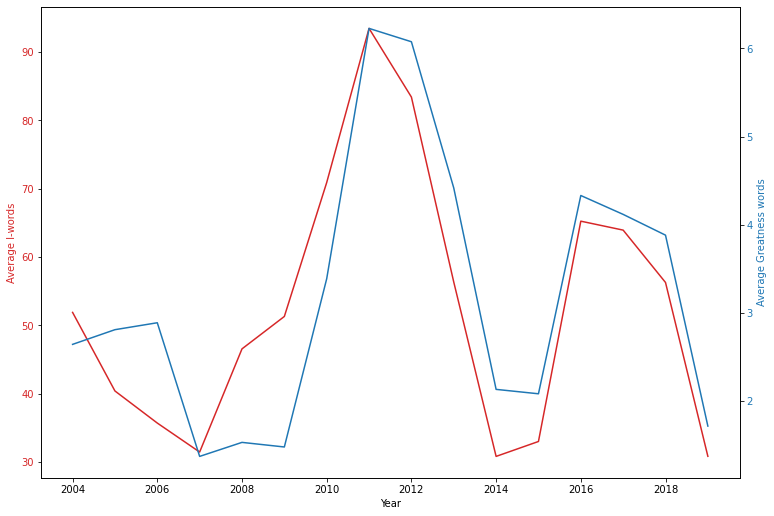

                  I-words  Greatness words
I-words          1.000000         0.869203
Greatness words  0.869203         1.000000


In [15]:
###################################
# 3. PLOTTING #
###################################

# Now we plot the data
# First we plot I-words and Greatness words
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average I-words', color=color)
ax1.plot(dfLyricsRolling["Year"], dfLyricsRolling["I-words"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Greatness words', color=color)
ax2.plot(dfLyricsRolling["Year"], dfLyricsRolling["Greatness words"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(12, 8)
plt.show()

# Let's also check the correlation between the two
print(dfLyricsRolling[["I-words", "Greatness words"]].corr())

#### 3.2 Vocabulary analysis
Next, let's look at the various measure of vocabulary. Total words and lexical diversity seem to have a somewhat strong negative correlation. The explanation for this could be that the more total words are used in a song, the more likely it becomes that more of them would be repeated. There is also a strong positive correlation between total words and unique words, which makes sense.

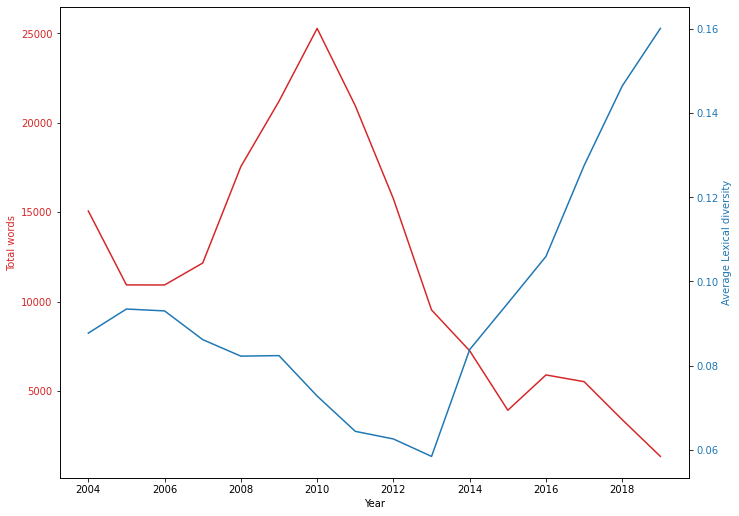

                   Total words  Vocabulary size  Lexical diversity
Total words           1.000000         0.988471          -0.708008
Vocabulary size       0.988471         1.000000          -0.637672
Lexical diversity    -0.708008        -0.637672           1.000000


In [17]:
# Then plot total words and lexical diversity
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total words', color=color)
ax1.plot(dfLyricsRolling["Year"], dfLyricsRolling["Total words"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Lexical diversity', color=color)
ax2.plot(dfLyricsRolling["Year"], dfLyricsRolling["Lexical diversity"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(12, 8)
plt.show()

# Let's also check the correlation between the two
print(dfLyricsRolling[["Total words", "Vocabulary size", "Lexical diversity"]].corr())


If we also look at vocabulary size (number of unique words) versus lexical density (ratio of non-stopwords to total words), we can see a weak negative correlation. Looking at trends, we can see a significant decreasing trend in terms of unique words since 2010, but an increasing trend in terms of density since 2012.

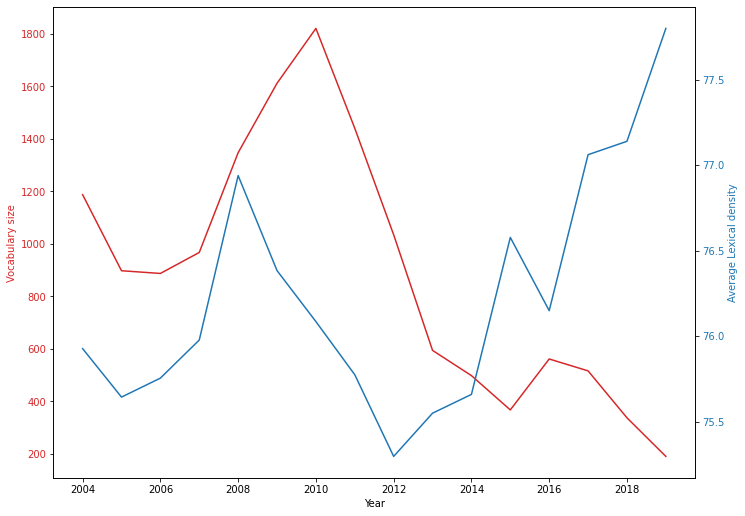

                   Vocabulary size  Lexical density  Lexical diversity
Vocabulary size           1.000000        -0.361631          -0.637672
Lexical density          -0.361631         1.000000           0.829396
Lexical diversity        -0.637672         0.829396           1.000000


In [23]:
# Then plot vocab. size and lexical density
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Vocabulary size', color=color)
ax1.plot(dfLyricsRolling["Year"], dfLyricsRolling["Vocabulary size"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Lexical density', color=color)
ax2.plot(dfLyricsRolling["Year"], dfLyricsRolling["Lexical density"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(12, 8)
plt.show()

# Let's also check the correlation between the two
print(dfLyricsRolling[["Vocabulary size", "Lexical density", "Lexical diversity"]].corr())

#### 3.3 Sentiment analysis
When we look at the average sentiment (polarity)* per year, there's no clear trend. The average sentiment seems to be slightly positive. There are dips around the same time periods that we saw in the lexicon analysis. The one in 2008 (mother's death) certainly makes sense, but the story isn't so clear in 2014 and 2019 (birth of children and gospel album respectively). There's also a peak in 2016, when the album The Life of Pablo was released.



*Polarity values range from -1 to 1, where -1 is negative, 1 is positive, and 0 is neutral.

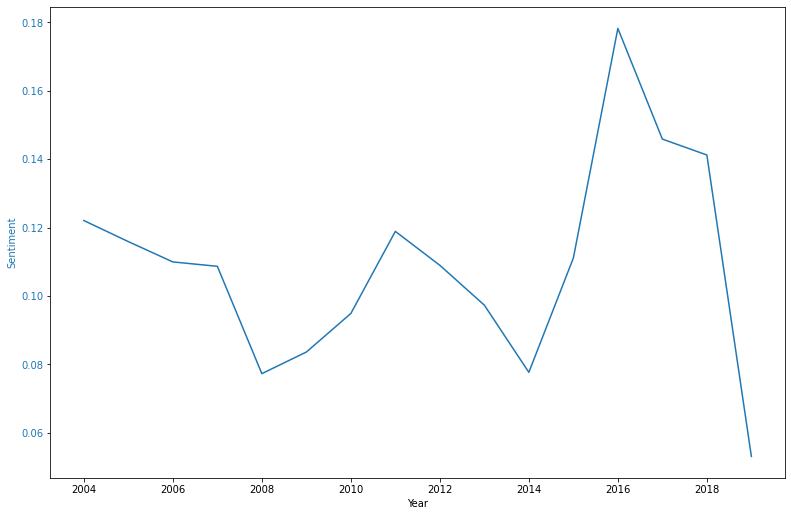

In [25]:
# Then plot sentiment
fig, ax = plt.subplots()

color = 'tab:blue'
ax.set_xlabel('Year')
ax.set_ylabel('Sentiment', color=color)
ax.plot(dfLyricsRolling["Year"], dfLyricsRolling["Sentiment"], color=color)
ax.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.set_size_inches(12, 8)
plt.show()

#### 3.4 Word Cloud

Finally, let's create a word cloud of all of Kanye's lyrics over the years.

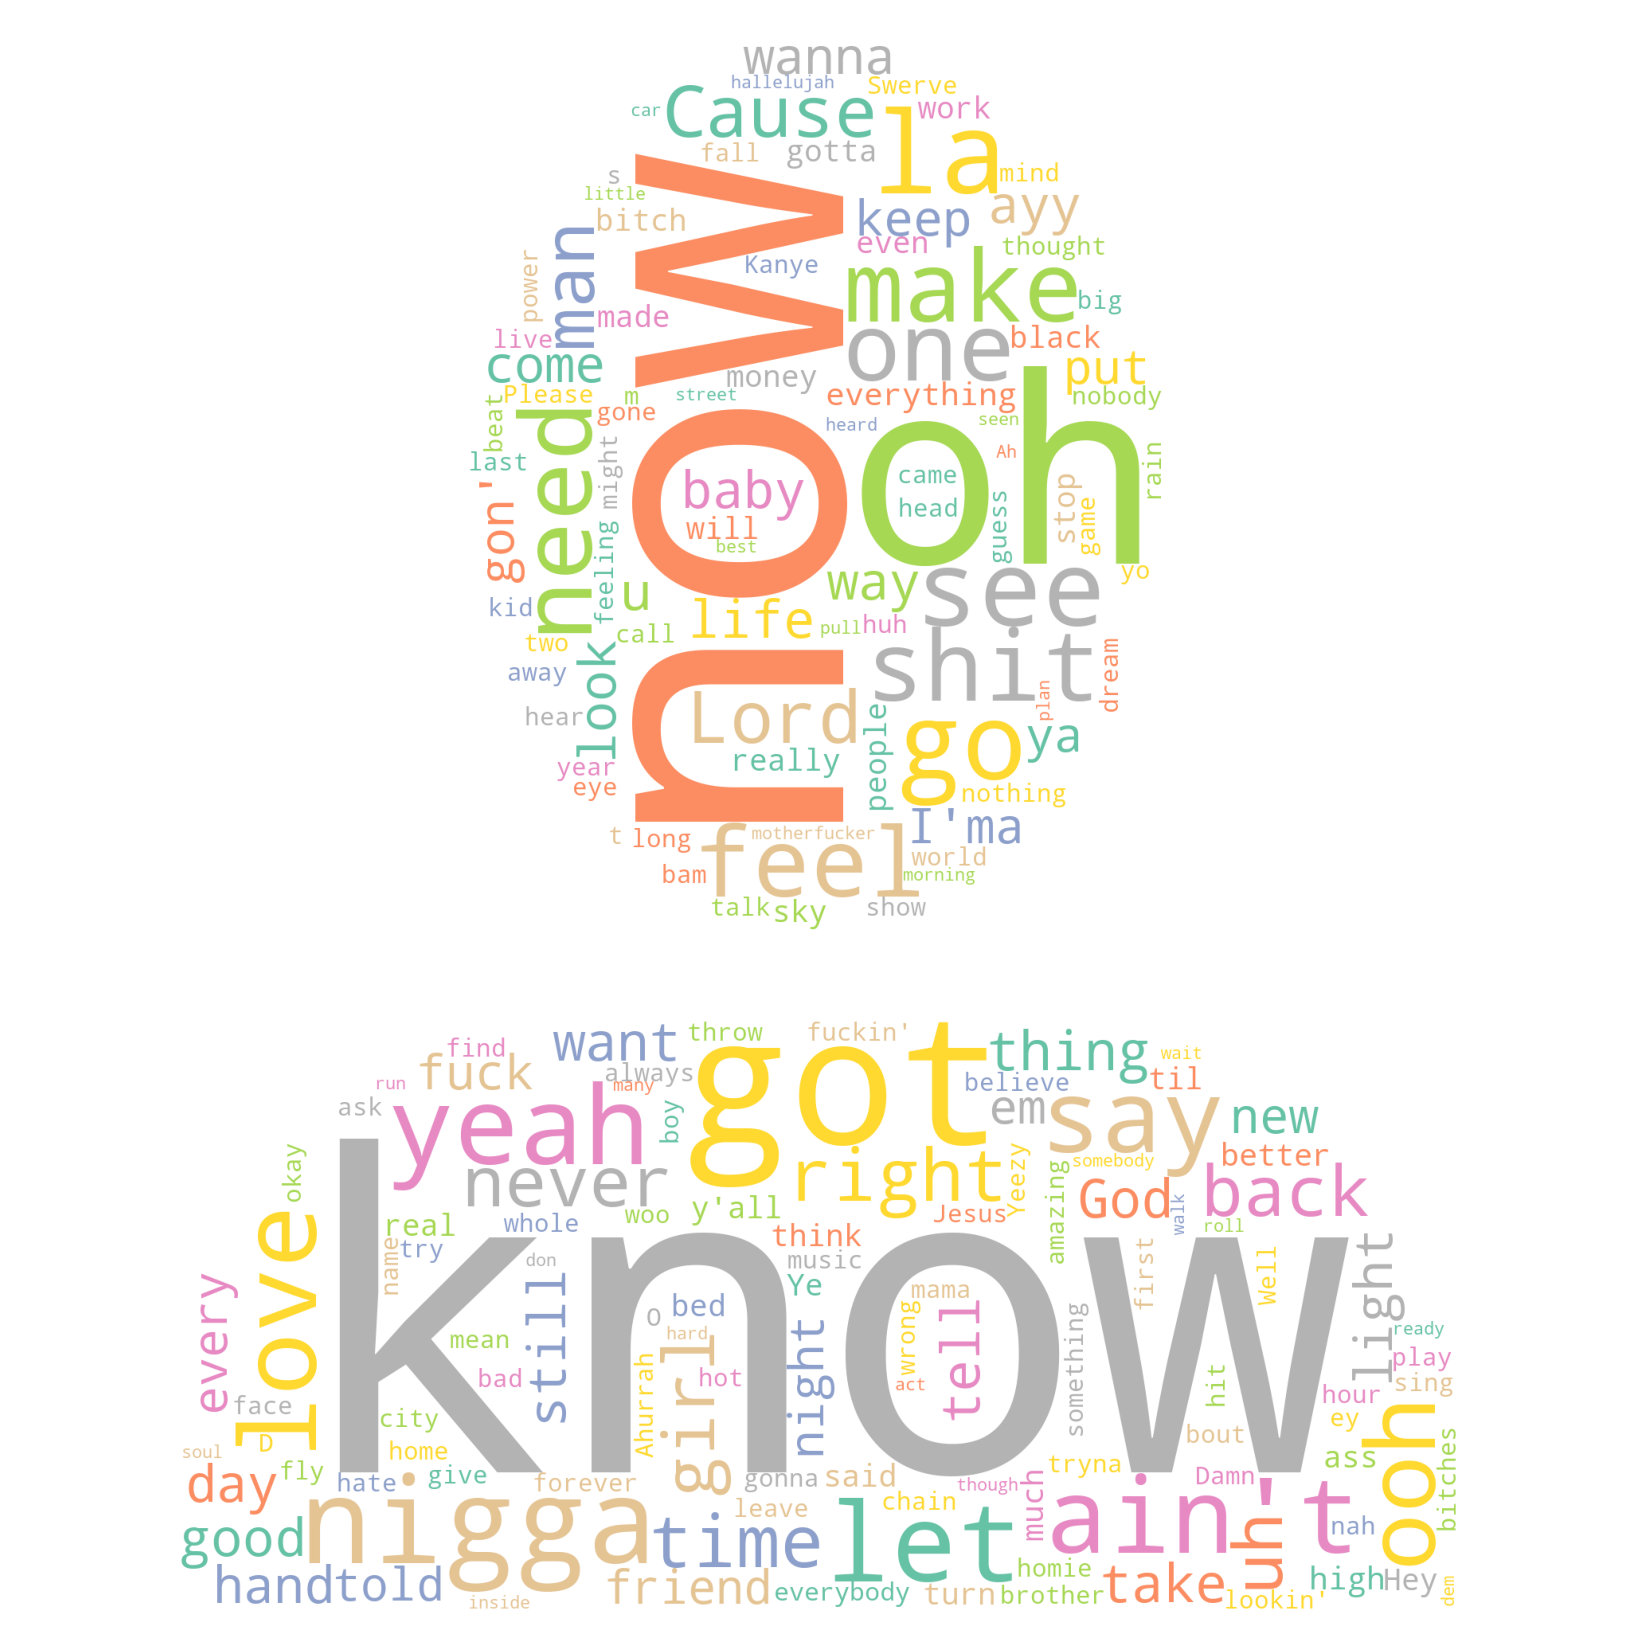

In [26]:
# Let's also create a word cloud of all of Kanye's lyrics
# Put all lyrics in a string
allLyrics = ""
for lyric in dfLyrics['Lyrics']:
    allLyrics += lyric + " "

# Create a mask to display the cloud in the shape of a person
mask = np.array(Image.open('user.png'))

# Create a word cloud and display it
wordCloud = WordCloud(width=3000, height=2000, random_state=3, background_color='white', colormap='Set2',
                      collocations=False, stopwords=STOPWORDS, mask=mask).generate(allLyrics)

plot_cloud(wordCloud)

# Conclusion